# Comparing CSDT and Scikit-Learn Decision Tree Classifiers

This notebook compares a custom implementation of a decision tree classifier (CSDT) with the Scikit-Learn `DecisionTreeClassifier`.
Detailed explanations and code implementations are provided.


## 1. Import Necessary Libraries

Here, we import libraries for:
- Data manipulation (`numpy`, `pandas`)
- Machine learning (`DecisionTreeClassifier`, `csdt`)
- Visualization (`matplotlib`)
- Metrics for evaluation (`mean_squared_error`)


In [1]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
from IPython.display import display
from IPython.display import Image
from sklearn.model_selection import train_test_split
import sys
base_folder = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(base_folder, "..")))
import csdt
from csdt import CSDT, split_criteria_with_methods



## 2. Set Global Variables and Configuration

This section defines:
- Random seed for reproducibility
- Hyperparameters for decision trees:
  - Minimum samples required to split a node or create a leaf
  - Maximum depth of the tree
- Names for features and the target column


In [2]:
SEED = 0
np.random.seed(SEED)

csdt_min_samples_split = 10
csdt_min_samples_leaf = 5
csdt_depth = 3
number_of_folds = 5
verbose = False

base_folder = os.getcwd()
features_list = [f'f{i}' for i in range(32)]  # Features are named f0, f1, ..., f31
target_list = ['target']


## 3. Load Dataset

We load the dataset into a Pandas DataFrame and split it into training and testing sets:
- **Features**: Columns named `f0`, `f1`, ..., `f31`
- **Target**: A column named `target`
- **Split**: 80% training, 20% testing


In [3]:
df = pd.read_csv(os.path.join(base_folder, "../datasets/student.csv"))

# Extract features and target columns
features_df = df[features_list]
target_df = df[target_list]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features_df, target_df, test_size=0.2, random_state=SEED
)


## 4. Define Utility Functions

### Gini Index Calculation
- Measures the impurity of a node.
- Formula: \( Gini = 1 - \sum{p_i^2} \), where \( p_i \) is the proportion of class \( i \).

### Majority Class Selection
- Returns the most frequent class in the dataset.


In [4]:
def calculate_gini(prediction, y):
    if y.size == 0 or np.unique(y).size == 1:  # Edge case: empty or pure dataset
        return 0
    classes, counts = np.unique(y, return_counts=True)
    probabilities = counts / counts.sum()
    return 1 - np.sum(probabilities ** 2)  # Gini calculation

def return_majority(y, x):
    if y.size == 0:  # Handle empty dataset
        raise ValueError("Cannot compute majority class for an empty dataset.")
    return [np.bincount(np.ravel(y).astype(np.int64)).argmax()]  # Most frequent class


## 5. Implement CSDT Model

Here, we:
- Configure the custom decision tree using hyperparameters and utility functions.
- Train the tree on the training set.


In [5]:
# Define custom split criteria using the previously defined functions
split_criteria = lambda y, x: split_criteria_with_methods(
    y, x, pred=return_majority, split_criteria=calculate_gini
)

# Initialize the custom decision tree (CSDT)
tree = CSDT(
    max_depth=csdt_depth,
    min_samples_leaf=csdt_min_samples_leaf,
    min_samples_split=csdt_min_samples_split,
    split_criteria=split_criteria,
    verbose=verbose,
)

# Train the model
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)  # Predict on the test set


## 6. Evaluate CSDT

We calculate the Gini index for predictions made by the custom decision tree.


In [6]:
ocdt_gini = calculate_gini(y_test, y_pred)
print(f"CSDT Gini: {ocdt_gini}")


CSDT Gini: 0.7421301775147928


## 7. Implement and Evaluate Scikit-Learn Decision Tree

We use Scikit-Learn's `DecisionTreeClassifier` to:
- Train a decision tree with the same hyperparameters as the CSDT.
- Evaluate it using the Gini index.


In [7]:
# Initialize the Scikit-Learn Decision Tree Classifier
classifier = DecisionTreeClassifier(
    min_samples_leaf=csdt_min_samples_leaf,
    min_samples_split=csdt_min_samples_split,
    max_depth=csdt_depth,
    random_state=10,
)

# Train the model
classifier.fit(X_train, y_train)

# Predict and evaluate
y_pred_sklearn = classifier.predict(X_test)
dt_gini = calculate_gini(y_test, y_pred_sklearn)
print(f"Scikit-Learn DT Gini: {dt_gini}")


Scikit-Learn DT Gini: 0.7421301775147928


## 8. Visualize Decision Trees

We generate visualizations for both:
1. The custom decision tree (CSDT)
2. Scikit-Learn's decision tree


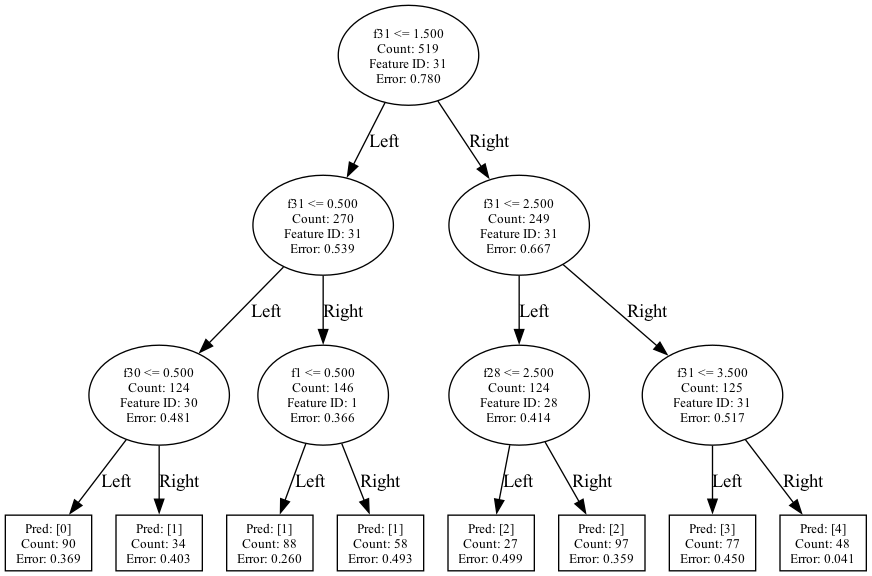

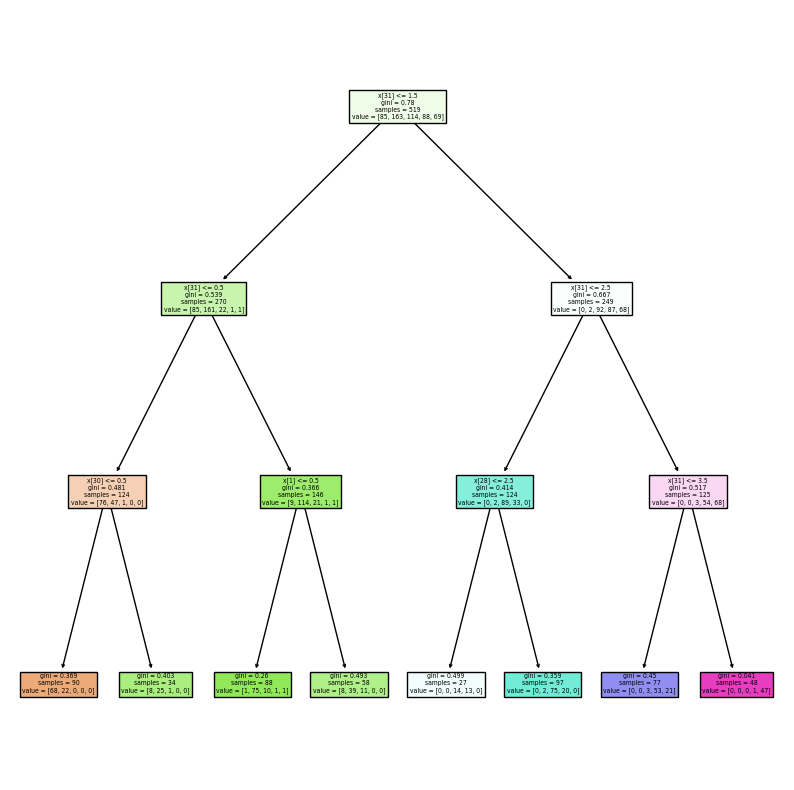

In [8]:
# Create output folder for saving visualizations
output_folder = "results"
os.makedirs(output_folder, exist_ok=True)

# Save CSDT visualization
csdt_output_path = os.path.join(output_folder, 'csdt_classifier')
dot = tree.draw_tree()
dot.render(csdt_output_path, format='png', view=True)
display(Image(filename=f"{csdt_output_path}.png"))

# Save Scikit-Learn tree visualization
plt.figure(figsize=(10, 10))
plot_tree(classifier, filled=True)
sklearn_output_path = os.path.join(output_folder, 'sklearn_classifier_dt.png')
plt.savefig(sklearn_output_path, format='png')
